<a href="https://colab.research.google.com/github/AntonAIG/e_commerce_analytics/blob/main/fond_rouge_ba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Business Analysis of Fond Rouge Customer Data

Fond Rouge Inc. is a French based company that build bespoke shoes for the global shoe market. They sell most of their products online, through the popular retail sites.
They have several brands of products from high-end luxery brands to general brands.

Table of Contents:
* Business Question
* Data Sources
* Data Analysis
* Visualization
* Conclusion

### Business Question
**Fond Rouge's** business performance can be evaluated from the *Sales*, *Revenue*, and *Sentiment* data provided for a specific region, or for the global business.

The Head of the USA market and the Product Engineer would like to evaluate the data sets they obtained, and identify why the US market is not perfroming well as the other markets. Therefore, we have to identify the KPIs that indicates performance based on the data sets we have.

The core business questions are:
> Where (geographically) did we observe issues?

> What could be the likely cause?

> What are the next steps we would suggest?

Through this notebook, I wish to provide business insights that will help us to understand the issues.

### Data Sources
The dataset originated from the global marketing team. It contains all the performance of Fond Rouge products accross the world.

There are three tables:
1. Sales: [`OrderID`, `Date`, `Country`, `City`, `Latitude`, `Longitude`, `ProductCategoryName`, `ProductID`, `Product`, `Quantity`, `Discount`, `Price`, `Status`]
2. Returns: [`OrderID`, `Status`]
3. Sentiment: [`Year_Month`, `Location`, `ProductID`, `Product`, `Sentiment`, `Class`]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re 
%matplotlib inline


Loading the data sets

In [ ]:
sales = pd.read_excel('/content/fond-rouge_data.xlsx', sheet_name='Sales')
returns = pd.read_excel('/content/fond-rouge_data.xlsx', sheet_name='Returns')
sentiment = pd.read_excel('/content/fond-rouge_data.xlsx', sheet_name='Sentiment')

sales schema

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9450 entries, 0 to 9449
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   OrderID              9450 non-null   object 
 1   Date                 9450 non-null   object 
 2   Country              9450 non-null   object 
 3   City                 9450 non-null   object 
 4   Latitude             9450 non-null   float64
 5   Longtitude           9450 non-null   float64
 6   ProductCategoryName  9450 non-null   object 
 7   ProductID            9450 non-null   object 
 8   Product              9450 non-null   object 
 9   Quantity             9450 non-null   int64  
 10  Discount             9450 non-null   float64
 11  Price                9450 non-null   float64
 12  Status               9450 non-null   object 
dtypes: float64(4), int64(1), object(8)
memory usage: 959.9+ KB


returns schema

In [ ]:
returns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   OrderID  838 non-null    object
 1   Status   838 non-null    object
dtypes: object(2)
memory usage: 13.2+ KB


sentiment schema

In [ ]:
sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10188 entries, 0 to 10187
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Year_Month   10188 non-null  object
 1   Location_ID  10188 non-null  object
 2   ProductID    10188 non-null  object
 3   Product      10188 non-null  object
 4   Sentiment    10188 non-null  int64 
 5   Class        10188 non-null  object
dtypes: int64(1), object(5)
memory usage: 477.7+ KB


In [ ]:
# searching for na values through the data
sales.isnull().sum()

OrderID                0
Date                   0
Country                0
City                   0
Latitude               0
Longtitude             0
ProductCategoryName    0
ProductID              0
Product                0
Quantity               0
Discount               0
Price                  0
Status                 0
dtype: int64

In [ ]:
returns.isnull().sum()

OrderID    0
Status     0
dtype: int64

In [ ]:
sentiment.isnull().sum()

Year_Month     0
Location_ID    0
ProductID      0
Product        0
Sentiment      0
Class          0
dtype: int64

There are no null values or empty points in the datasets

Let's have a look at the summary statistics

In [ ]:
sales.describe()

,Latitude,Longtitude,Quantity,Discount,Price
count,9450.000000,9450.000000,9450.000000,9450.000000,9450.000000
mean,46.759233,-8.095997,5.487196,2.728293,54.435442
std,6.123109,34.003086,2.877080,1.972812,20.799806
min,32.831200,-118.406800,1.000000,0.000000,35.900000
25%,41.893100,-3.514750,3.000000,1.210000,39.950000
50%,48.864716,2.349014,5.000000,2.450000,45.610000
75%,51.507200,12.482800,8.000000,3.680000,78.560000
max,60.175600,26.083300,10.000000,10.290000,102.950000


In [ ]:
sentiment.describe()

,Sentiment
count,10188.000000
mean,84.269729
std,10.772830
min,40.000000
25%,84.000000
50%,87.000000
75%,90.000000
max,92.000000


There are cheapest product sold for $35.90 while the most expensive sold for $102.95.

The highest sentiment is 92.00% while the lowest is 40.00%

Let's find out if there are any sales without `COMPLETED` status

In [ ]:
sales.query("Status != 'COMPLETED'")
#sales[sales['Status']!='COMPLETED']

,OrderID,Date,Country,City,Latitude,Longtitude,ProductCategoryName,ProductID,Product,Quantity,Discount,Price,Status


In [ ]:
#test for primary key
sales.shape[0] == sales['OrderID'].nunique()

True

In [ ]:
returns.shape[0] == returns['OrderID'].nunique()

True

In [ ]:
all(returns['OrderID']) in sales['OrderID']

True

Merge is possible

In [ ]:
#sr = sales returns
sr = pd.merge(sales, returns, how='left', on='OrderID')
sr.shape[0]

9450

In [ ]:
# perform the date split and convert to datetime object

# sr.query('Price > 50 and Quantity > 4')
# sr.query('ProductCategoryName.str.startswith("Bro")', engine="python")
# sr.query('Price < 50 and Status_x == "COMPLETED"')

The next merge will be by `ProductID` since it is the `PK` from sentiment.

People tend to submit reviews on products. Before doing this, we need to split the columns `Date`, to `Year_Month` and `Location_ID` to `Country` and `City`in their respective tables

In [ ]:
# let's merge the status columns
# replace COMPLETED with RETURNED

for s in range(len(sr['Status_y'])):
  if sr['Status_y'][s] == 'RETURNED':
    sr['Status_x'][s] = 'RETURNED'
  else:
    s+=1

sr.drop('Status_y', inplace=True, axis=1)
sr.rename(columns={'Status_x': 'Status'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# let's split the date
ym = []
for date in sr['Date']:
  y = date.split("/", -1)[:2]
  y_m = "/".join(y)
  ym.append(y_m)
sr['Year_Month'] = ym

In [ ]:
# let's join the Country and City in the sr table
sr['Location_ID'] = sr['Country'] + ", " + sr['City']

In [ ]:
sr.columns

Index(['OrderID', 'Date', 'Country', 'City', 'Latitude', 'Longtitude',
       'ProductCategoryName', 'ProductID', 'Product', 'Quantity', 'Discount',
       'Price', 'Status', 'Year_Month', 'Location_ID'],
      dtype='object')

In [ ]:
sentiment.columns

Index(['Year_Month', 'Location_ID', 'ProductID', 'Product', 'Sentiment',
       'Class'],
      dtype='object')

In [ ]:
srs = pd.merge(sr, sentiment, how='left', on=['Location_ID', 'Year_Month', 'ProductID'])
srs.shape[0]

9450

In [ ]:
srs.head()

,OrderID,Date,Country,City,Latitude,Longtitude,ProductCategoryName,ProductID,Product_x,Quantity,Discount,Price,Status,Year_Month,Location_ID,Product_y,Sentiment,Class
0,order-9dd87a4c-7374-446a-845b-37fa211c121a,2019/2/8,Belgium,Brussels,50.850346,4.351721,Brogues,product-124ef52a-c7c3-48af-b315-33a14b2f6e1d,François,7,3.96,41.45,COMPLETED,2019/2,"Belgium, Brussels",François,84,NEU
1,order-47acd540-c1dd-47a8-a5dc-39cee5c43a5e,2019/3/10,Belgium,Brussels,50.850346,4.351721,Brogues,product-a19d1434-d5f2-4a2a-9fe0-7d70f63e391e,Denis,9,1.42,58.95,COMPLETED,2019/3,"Belgium, Brussels",Denis,83,NEU
2,order-fd686823-060b-4d59-bd0a-512f87eb6654,2019/4/10,Belgium,Brussels,50.850346,4.351721,Flats,product-0a97c64c-582b-41a9-b367-2a4e081cf3d5,Estelle,5,2.14,45.61,COMPLETED,2019/4,"Belgium, Brussels",Estelle,86,POS
3,order-6e3e2947-bf9c-4993-9215-307d1a61cf92,2019/5/24,Belgium,Brussels,50.850346,4.351721,Platforms,product-642f72ba-c5d6-4126-be0f-a22fe4e9fbb6,Bella,8,4.55,46.93,COMPLETED,2019/5,"Belgium, Brussels",Bella,84,NEU
4,order-28117cd2-a47e-42ef-a619-fe52ec2cd7b2,2019/6/22,Belgium,Brussels,50.850346,4.351721,Stilettos,product-fa4a41fc-4a31-44b5-953f-8e2a45b43673,Cecile,4,3.92,78.56,COMPLETED,2019/6,"Belgium, Brussels",Cecile,87,POS


### Data Analysis
In this section, we shall create additional features that represent calculated fields using simple arithimetic or numpy functions

In [ ]:
srs['Revenue'] = srs['Price']*srs['Quantity']-srs['Discount']

In [ ]:
# split the revenue column into Revenue and Refund using Status
refund = []
revenue = []
for r in range(srs.shape[0]):
  if srs['Status'][r] == 'COMPLETED':
    refund.append(0.0)
    revenue.append(srs['Revenue'][r])
  else:
    refund.append(srs['Revenue'][r])
    revenue.append(0.0)
    r+=1
srs['Refund'] = refund
srs['Revenue'] = revenue

In [ ]:
srs.columns

Index(['OrderID', 'Date', 'Country', 'City', 'Latitude', 'Longtitude',
       'ProductCategoryName', 'ProductID', 'Product_x', 'Quantity', 'Discount',
       'Price', 'Status', 'Year_Month', 'Location_ID', 'Product_y',
       'Sentiment', 'Class', 'Revenue', 'Refund'],
      dtype='object')

In [ ]:
# select relevant columns
cols = ['Country', 'City', 'Latitude', 'Longtitude','Status', 'Sentiment',
       'Class', 'Revenue', 'Refund']
data = srs[cols]

In [ ]:
# cities and cordinates = cities_co
cities_co = data.drop_duplicates(subset=['City'])
cities_co.drop(['Status','Sentiment','Class','Revenue','Refund'],
                     inplace=True, axis=1)
cities_co.sort_values(by='City', ascending=True, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
# refund, revenue per city
# group by city

city_rr = data.groupby('City').sum()
rr = city_rr[['Revenue',	'Refund']]
cities_co['Revenue'] = list(city_rr['Revenue'])
cities_co['Refund'] = list(city_rr['Refund'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
cities_co.head()

,Country,City,Latitude,Longtitude,Revenue,Refund
5094,Netherlands,Amsterdam,52.350000,4.916600,156917.80,7284.82
8786,United States,Atlanta,33.762700,-84.422400,70585.10,7510.33
1207,Germany,Berlin,52.520008,13.404954,11904.24,1193.19
0,Belgium,Brussels,50.850346,4.351721,126599.25,9616.19
6515,Romania,Bucharest,44.400000,26.083300,11615.24,1778.42


In [ ]:
# average sentiment

avg_sent = data.groupby('City').mean().sort_values(by='City')
cities_co['Avg_Sent'] = list(avg_sent['Sentiment'])
cities_co.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Country,City,Latitude,Longtitude,Revenue,Refund,Avg_Sent
5094,Netherlands,Amsterdam,52.350000,4.916600,156917.80,7284.82,87.485130
8786,United States,Atlanta,33.762700,-84.422400,70585.10,7510.33,87.435115
1207,Germany,Berlin,52.520008,13.404954,11904.24,1193.19,87.600000
0,Belgium,Brussels,50.850346,4.351721,126599.25,9616.19,87.144050
6515,Romania,Bucharest,44.400000,26.083300,11615.24,1778.42,87.088889


In [ ]:
cities_co.to_csv('cities_summary.csv', index=False)

In [ ]:
import folium

def location(city):
  x = float(cities_co[cities_co['City']==city]['Latitude'])
  y = float(cities_co[cities_co['City']==city]['Longtitude'])
  return [x,y]

m = folium.Map(location=location('Berlin'), zoom_start=3)

for city in cities_co['City']:
  folium.Marker(location=location(city), popup=city,
                tooltip="Click for more information").add_to(m)
m

In [ ]:
m2 = folium.Map(location=location('Berlin'), tiles="OpenStreetMap", zoom_start=4)

for i, city in enumerate(cities_co['City']):
  folium.Circle(
      location=location(city),
      popup=city,
      radius=cities_co['Revenue'].iloc[i],
      color='crimson',
      fill=True,
      fill_colr='crimson'
  ).add_to(m2)

m2

In [ ]:
m3 = folium.Map(location=location('Berlin'), tiles="OpenStreetMap", zoom_start=4)



In [ ]:
!pip install geopandas

     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 16.7 MB 45.1 MB/s 
     |████████████████████████████████| 6.3 MB 43.2 MB/s 


In [ ]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

In [ ]:
geometry = [Point(xy) for xy in zip(cities_co['Latitude'], cities_co['Longtitude'])]
gdf = GeoDataFrame(cities_co, geometry=geometry)

gdf.head()

,Country,City,Latitude,Longtitude,Revenue,Refund,Avg_Sent,geometry
5094,Netherlands,Amsterdam,52.350000,4.916600,156917.80,7284.82,87.485130,POINT (52.35000 4.91660)
8786,United States,Atlanta,33.762700,-84.422400,70585.10,7510.33,87.435115,POINT (33.76270 -84.42240)
1207,Germany,Berlin,52.520008,13.404954,11904.24,1193.19,87.600000,POINT (52.52001 13.40495)
0,Belgium,Brussels,50.850346,4.351721,126599.25,9616.19,87.144050,POINT (50.85035 4.35172)
6515,Romania,Bucharest,44.400000,26.083300,11615.24,1778.42,87.088889,POINT (44.40000 26.08330)


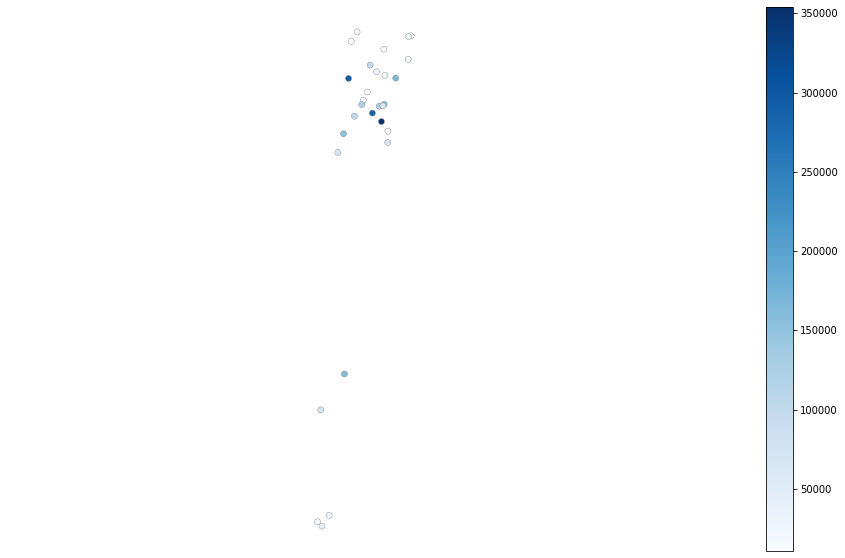

In [ ]:
fig, ax = plt.subplots(figsize=(16,10))
gdf.plot(ax=ax, column='Revenue', cmap='Blues', edgecolor='grey',
         linewidth=0.4, legend=True)
ax.axis("off")
plt.axis('equal')
plt.show()

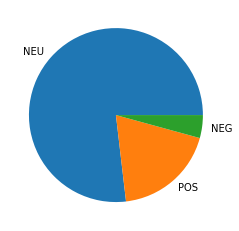

In [ ]:
# global sentiment classification
names = data['Class'].unique()
uniques = list(data['Class'].value_counts())
plt.pie(uniques, labels=names)
plt.show()

In [ ]:
test = data.groupby(['Country', 'City', 'Class', 'Status']).sum()
test.head()

Latitude   Longtitude  Sentiment  \
Country City     Class Status                                            
Austria Vienna   NEU   COMPLETED   3422.789300  1162.490100       5914   
                       RETURNED      48.208300    16.373100         83   
                 POS   COMPLETED  13642.948900  4633.587300      24924   
                       RETURNED     819.541100   278.342700       1504   
Belgium Brussels NEU   COMPLETED   4779.932524   409.061774       7848   

                                   Revenue   Refund  
Country City     Class Status                        
Austria Vienna   NEU   COMPLETED  19384.64     0.00  
                       RETURNED       0.00   314.82  
                 POS   COMPLETED  82963.50     0.00  
                       RETURNED       0.00  4066.94  
Belgium Brussels NEU   COMPLETED  27478.19     0.00

In [ ]:
test.reset_index(inplace=True)
test.head()

,Country,City,Class,Status,Latitude,Longtitude,Sentiment,Revenue,Refund
0,Austria,Vienna,NEU,COMPLETED,3422.789300,1162.490100,5914,19384.64,0.00
1,Austria,Vienna,NEU,RETURNED,48.208300,16.373100,83,0.00,314.82
2,Austria,Vienna,POS,COMPLETED,13642.948900,4633.587300,24924,82963.50,0.00
3,Austria,Vienna,POS,RETURNED,819.541100,278.342700,1504,0.00,4066.94
4,Belgium,Brussels,NEU,COMPLETED,4779.932524,409.061774,7848,27478.19,0.00


In [ ]:
#for index, row in test.iterrows():
  #print(index, row.City, row.Revenue)

tests = test.copy()

In [ ]:
tests.select_dtypes(include=[np.number]).dtypes

Latitude      float64
Longtitude    float64
Sentiment       int64
Revenue       float64
Refund        float64
dtype: object